# Import libary

In [44]:
import sasktran as sk
import numpy as np
import datetime as dt
import time as T
import cv2
from joblib import Parallel, delayed
import numba as nb
import os
import paramiko
from scp import SCPClient
import subprocess
from scipy.stats import gaussian_kde
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib.transforms as mtransforms

# Function

In [10]:
class AHI_angle:
    def __init__(self,date,):
        self.date = date      
        
    def read_angle_data(self):
    
        AHI_date = self.date[4:11]
        
        sza_file_name = 'AHI_SZA_2020{}5.dat'.format(AHI_date)
        saa_file_name = 'AHI_SAA_2020{}5.dat'.format(AHI_date)
        
        with open(SZA_PATH + sza_file_name,'rb') as fp:
            AHI_SZA = np.frombuffer(fp.read(),dtype='u2').reshape(3000,3000) / 100
            AHI_SZA=cv2.resize(np.array(AHI_SZA,dtype='float64'),(12000,12000),interpolation=cv2.INTER_NEAREST)
        
        with open(SAA_PATH + saa_file_name,'rb') as fp:
            AHI_SAA = np.frombuffer(fp.read(),dtype='u2').reshape(3000,3000) / 100
            AHI_SAA=cv2.resize(np.array(AHI_SAA,dtype='float64'),(12000,12000),interpolation=cv2.INTER_NEAREST)        
        return AHI_SZA,AHI_SAA
class H8_data:

    def __init__(self , account , pw , band , band_number , date):
        self.account = account
        self.pw = pw
        self.band = band
        self.band_number = band_number
        self.date = date
    
    def get_path(self):
        return '/data01/GEO/ORGDATA/H8AHI/hmwr829gr.cr.chiba-u.ac.jp/gridded/FD/V20151105/' + self.date[0:6] + '/' + self.band.upper() + '/'

    def get_filename(self):
        return self.date + "." + self.band + "." + self.band_number + ".fld.geoss.bz2"
    
    def DN2TBB(self,data):
        LUT=np.loadtxt(DN_PATH + 'count2tbb_v102/' + self.band + "." + self.band_number)
        return LUT[data,1]
    
    def file_path(self):
        return self.get_path() + self.get_filename() 
                 
    def download_H8data(self):
        client = paramiko.SSHClient()
        client.load_system_host_keys()
        client.set_missing_host_key_policy(paramiko.AutoAddPolicy())
        client.connect(hostname='10.4.123.47', port=22, username=self.account, password=self.pw)
        scp = SCPClient(client.get_transport())
        sftp = client.open_sftp()

        try :
            sftp.stat(self.file_path())

        except FileNotFoundError:
            print("File Not Found")
            return 'No data'

        else:
            scp.get(self.file_path(), folder_original+'/')
            p = subprocess.Popen('lbzip2 -d {}{}'.format(folder_original+'/',self.file_path()[-33:]),shell=True)
            p.communicate()
            print ('Himawari8/AHI data Processed Finish')
            return folder_original + '/' + self.get_filename()[:-4]
            
    def read_H8data(self):
        H8_file_path = self.download_H8data()
        if self.band == "vis":
            sr = 12000
        elif self.band == "ext":
            sr = 24000
        else:
            sr = 6000
        if H8_file_path != 'No data':
            with open(H8_file_path,'rb') as fp:
                data = np.frombuffer(fp.read(),dtype='>u2').reshape(sr,sr)
                data = self.DN2TBB(data)
                data = data/100

            print("data reading finish")
            return data
        else:
            return 'No data'
        

In [76]:
def Time_split(time):
    YYYY = time.strftime('%Y')
    MM = time.strftime('%m')
    DD = time.strftime('%d')
    HH = time.strftime('%H')
    MIN = time.strftime('%M')
    date = YYYY + MM + DD + HH + MIN
    return YYYY,MM,DD,HH,MIN,date

def time2mjd(dateT):
    t0=dt.datetime(1858,11,17,0,0,0,0)
    mjd=(dateT-t0).days
    mjd_s=dateT.hour*3600.0+dateT.minute*60.0+dateT.second+dateT.microsecond/1000000.0
    return mjd+mjd_s/86400.0

def Get_Kernel_Input_Parameter(date,band):
    AHI_SZA,AHI_SAA = AHI_angle(date).read_angle_data()
    RAA = abs(AHI_SAA - VAA)
    RAA[RAA>180]=360-RAA[RAA>180]
    if band == 4:
        if os.path.exists(SR_PATH + '{}_AC/{}_b04.dat'.format(date,date)):
            with open(SR_PATH + '{}_AC/{}_b04.dat'.format(date,date),'rb') as fp:
                SR = np.frombuffer(fp.read(),dtype='f4').reshape(12000,12000)
        else:
            return 'None','None','None'
    if band == 3:
        if os.path.exists(SR_PATH + '{}_AC/{}_b03.dat'.format(date,date)):
            with open(SR_PATH + '{}_AC/{}_b03.dat'.format(date,date),'rb') as fp:
                SR = np.frombuffer(fp.read(),dtype='f4').reshape(24000,24000)
                SR = SR.reshape(12000,2,12000,2).mean(-1).mean(1)
        else:
            return 'None','None','None'
        
    return SR[1000:4000,3500:6500],RAA[1000:4000,3500:6500],AHI_SZA[1000:4000,3500:6500]

def Volume_Kernel(wavel_nm,latitude,longitude,mjd,Cos_SZA,Cos_VZA,Cos_RAA):
    brdf = sk.RossThickKernel()
    vol = brdf.reflectance(wavel_nm,latitude,longitude,mjd,Cos_SZA,Cos_VZA,Cos_RAA)
    return vol

def Geometric_Kernel(wavel_nm,latitude,longitude,mjd,Cos_SZA,Cos_VZA,Cos_RAA):
    brdf = sk.LiSparseReciprocalKernel(crown_shape=1.0, relative_height=2.0)
    geo = brdf.reflectance(wavel_nm,latitude,longitude,mjd,Cos_SZA,Cos_VZA,Cos_RAA)
    return geo



def MODIS_Kernel_BRDF(band,idx_row,idx_col): 
    if band == 3:
        if Ocean_cloud_mask[idx_row,idx_col] == True:
            kvol = Volume_Kernel(640,lat[idx_row],lon[idx_col],MJD,np.cos(np.radians(SZA[idx_row,idx_col])),np.cos(np.radians(VZA[idx_row,idx_col])),np.cos(np.radians(RAA[idx_row,idx_col])))
            kgeo = Geometric_Kernel(640,lat[idx_row],lon[idx_col],MJD,np.cos(np.radians(SZA[idx_row,idx_col])),np.cos(np.radians(VZA[idx_row,idx_col])),np.cos(np.radians(RAA[idx_row,idx_col])))
            return kvol,kgeo
        else:
            return np.nan,np.nan
    elif band == 4:
        if Ocean_cloud_mask[idx_row,idx_col] == True:
            kvol = Volume_Kernel(860,lat[idx_row],lon[idx_col],MJD,np.cos(np.radians(SZA[idx_row,idx_col])),np.cos(np.radians(VZA[idx_row,idx_col])),np.cos(np.radians(RAA[idx_row,idx_col])))
            kgeo = Geometric_Kernel(860,lat[idx_row],lon[idx_col],MJD,np.cos(np.radians(SZA[idx_row,idx_col])),np.cos(np.radians(VZA[idx_row,idx_col])),np.cos(np.radians(RAA[idx_row,idx_col])))
            return kvol,kgeo
        else:
            return np.nan,np.nan

def Mask_Merge(date):
    # Read cloud mask
    # cloud 0, clear 1
    with open('/data01/people/liwei/Data/cm_120-150E_20-50N/{}_cloudmask.dat'.format(date),'rb') as fp:
        cloudmask = np.frombuffer(fp.read(),dtype='<f4').reshape(1500,1500)
        cloudmask = cv2.resize(np.array(cloudmask,dtype='float32'),(3000,3000),interpolation=cv2.INTER_NEAREST)
        cloudmask = cloudmask.astype(bool)
        
    MASK = (Ocean_mask + cloudmask)
    MASK = np.where(MASK==2,1,0)
    
    return MASK

# @nb.jit()
# def get_water_idx():
#     Om = Ocean_mask.reshape(-1)
#     Water_idx = []
#     for i in range(3000*3000):
#         if Om[i] == True:
#             Water_idx.append(i)
#     return Water_idx

def H8_Process(ACCOUNT,PW,Band,Band_number,Date):
    data = H8_data(ACCOUNT,PW,Band,Band_number,Date).read_H8data()
    return data



# MAIN FUNCTION

In [4]:
SR_PATH = '/data01/people/liwei/AC_Result/'
VZA_PATH = '/data01/GEO/INPUT/ANGLE/Viewer_Zenith_Angle/AHI_VZA_10.dat'
VAA_PATH = '/data01/GEO/INPUT/ANGLE/Viewer_Azimuth_Angle/AHI_VAA_10.dat'
LAND_MASK_PATH = '/data01/GEO/INPUT/LAND_MASK/Landmask_10.dat'
SZA_PATH = '/data01/GEO/INPUT/ANGLE/Solar_Zenith_Angle_u2/'
SAA_PATH = '/data01/GEO/INPUT/ANGLE/Solar_Azimuth_Angle_u2/'

# AHI VZA/VAA Load
with open(VZA_PATH,'rb') as fp:
    VZA = np.frombuffer(fp.read(),dtype='u2').reshape(12000,12000)[1000:4000,3500:6500] / 100
with open(VAA_PATH,'rb') as fp:
    VAA = np.frombuffer(fp.read(),dtype='u2').reshape(12000,12000) / 100
with open(LAND_MASK_PATH,'rb') as fp:
    Ocean_mask = np.frombuffer(fp.read(),dtype='u1').reshape(12000,12000)[1000:4000,3500:6500].astype('bool')
res = 0.01
lat = np.linspace(50 - res/2 ,20 + res/2,3000)
lon = np.linspace(120 + res/2 ,150 - res/2,3000)

In [12]:
date_start = '2018-07-21 00:00'
date_end = '2018-07-21 00:00'
date_t = dt.timedelta(minutes=10)
# date_t = dt.timedelta(minutes=30)
date_s = dt.datetime.strptime(date_start, "%Y-%m-%d %H:%M")
date_e = dt.datetime.strptime(date_end, "%Y-%m-%d %H:%M")
date_time_now = date_s
b = 4
kvol = []
kgeo = []
Ref = []
time_list = []
while date_time_now <= date_e:
    print(date_time_now)
    start_time = T.time()
    YYYY,MM,DD,HH,MIN,date= Time_split(date_time_now)
    Ocean_cloud_mask = Mask_Merge(date)
    SR,RAA,SZA = Get_Kernel_Input_Parameter(date,b)
    if SR[0][0] == 'N':
        date_time_now = date_time_now + date_t
        continue
    MJD = time2mjd(date_time_now)
    Kresult = Parallel(n_jobs=30)(delayed(MODIS_Kernel_BRDF)(b,i,j) for i in range(3000) for j in range(3000))
    kvol.append(np.array(Kresult)[:,0].reshape(3000,3000)[Ocean_cloud_mask])
    kgeo.append(np.array(Kresult)[:,1].reshape(3000,3000)[Ocean_cloud_mask])
    Ref.append(SR[Ocean_mask])
    time_list.append(date)
    
    
    end_time = T.time()
    TIME = end_time - start_time
    print('time: {:.1f} secs, {:.1f} mins,{:.1f} hours'.format(TIME,TIME/60,TIME/3600))
    date_time_now = date_time_now + date_t

2018-07-21 00:00:00
time: 102.9 secs, 1.7 mins,0.0 hours


In [20]:
date

'201807210000'

In [34]:
with open('/data01/people/liwei/Data/cm_120-150E_20-50N/{}_cloudmask.dat'.format(date),'rb') as fp:
        cloudmask = np.frombuffer(fp.read(),dtype='<f4').reshape(1500,1500)
        cloudmask=cv2.resize(np.array(cloudmask,dtype='float32'),(3000,3000),interpolation=cv2.INTER_NEAREST)

In [35]:
cm = cloudmask.astype('bool')

In [32]:
import numpy.ma as ma

In [ ]:
SR_mask = ma.array(SR,mask=~cm,fill_value=np.nan)

In [ ]:
SR_mask = SR[cm]

In [ ]:
sr = SR_mask.filled()

In [ ]:
sr = np.where(sr==-9999,np.nan,sr)

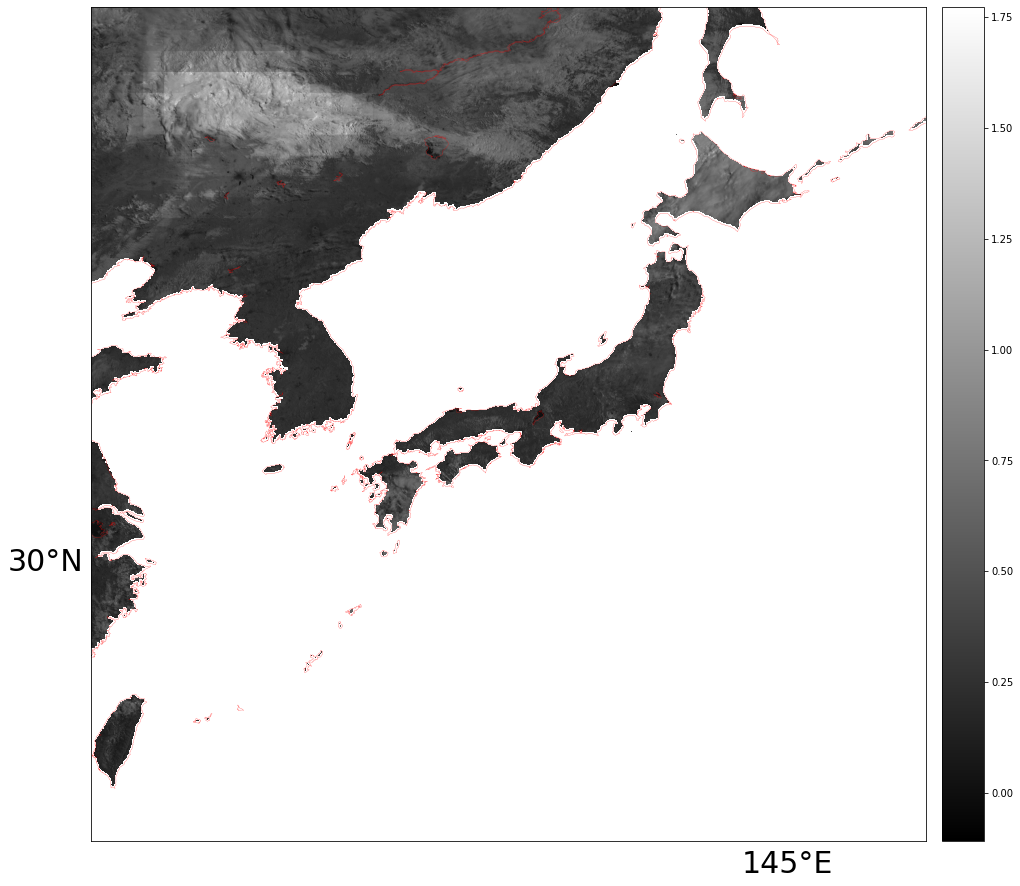

In [48]:
fig = plt.figure(figsize=(16,16))
m = Basemap(projection='cyl', resolution='i',
            llcrnrlat=20, urcrnrlat = 50,
            llcrnrlon=120, urcrnrlon = 150,
            lon_0=155, lat_0=0)  

m.drawcoastlines(linewidth=0.2,color='r')
m.drawparallels(np.arange(-60, 61, 30), labels=[1,0,0,0], fontsize=30,linewidth=0)
m.drawmeridians(np.arange(85, 206, 30), labels=[0,0,0,1], fontsize=30,linewidth=0)

m.imshow(SR,origin='upper',cmap = 'gray',interpolation = None)
cb = m.colorbar()
# cb.set_ticks(np.linspace(0.5,15.5,17))
# cb.set_ticklabels(labels,size=20)
# plt.title('MODIS Land cover \n MCD12Q1',fontsize='30',y=1.01)
plt.show()

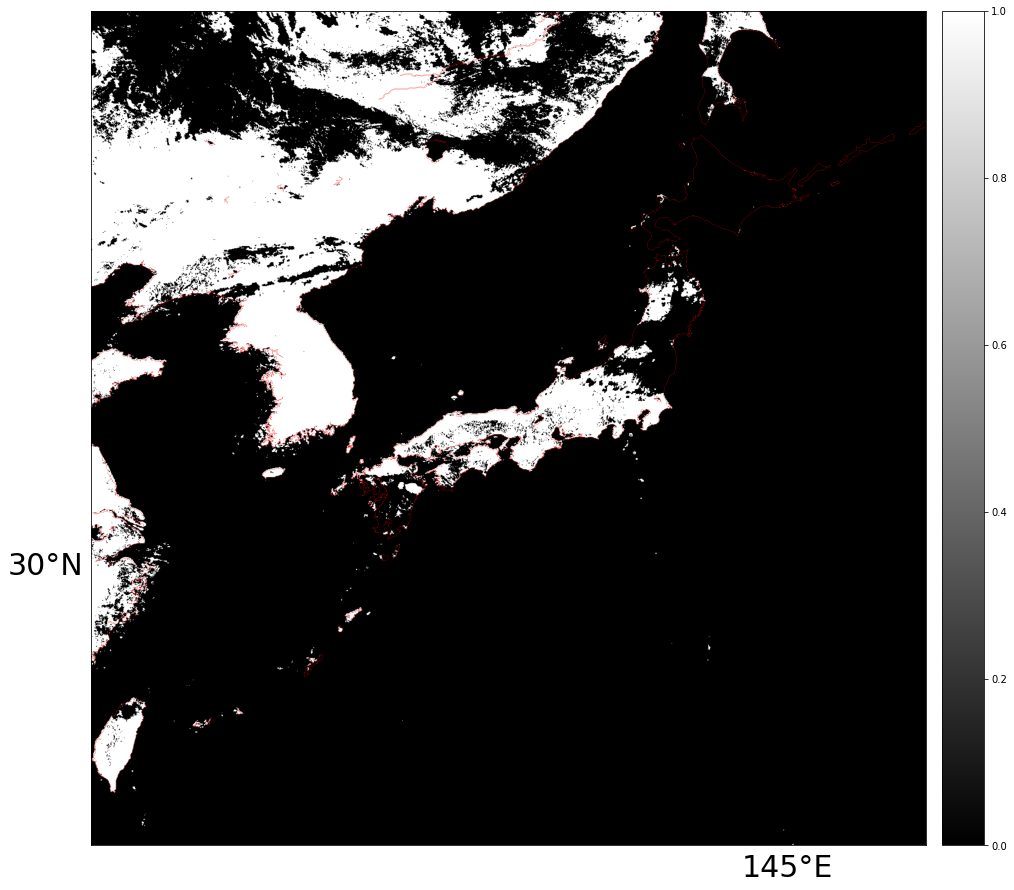

In [47]:
fig = plt.figure(figsize=(16,16))
m = Basemap(projection='cyl', resolution='i',
            llcrnrlat=20, urcrnrlat = 50,
            llcrnrlon=120, urcrnrlon = 150,
            lon_0=155, lat_0=0)  

m.drawcoastlines(linewidth=0.2,color='r')
m.drawparallels(np.arange(-60, 61, 30), labels=[1,0,0,0], fontsize=30,linewidth=0)
m.drawmeridians(np.arange(85, 206, 30), labels=[0,0,0,1], fontsize=30,linewidth=0)

m.imshow(cm,origin='upper',cmap = 'gray',interpolation = None)
cb = m.colorbar()
# cb.set_ticks(np.linspace(0.5,15.5,17))
# cb.set_ticklabels(labels,size=20)
# plt.title('MODIS Land cover \n MCD12Q1',fontsize='30',y=1.01)
plt.show()

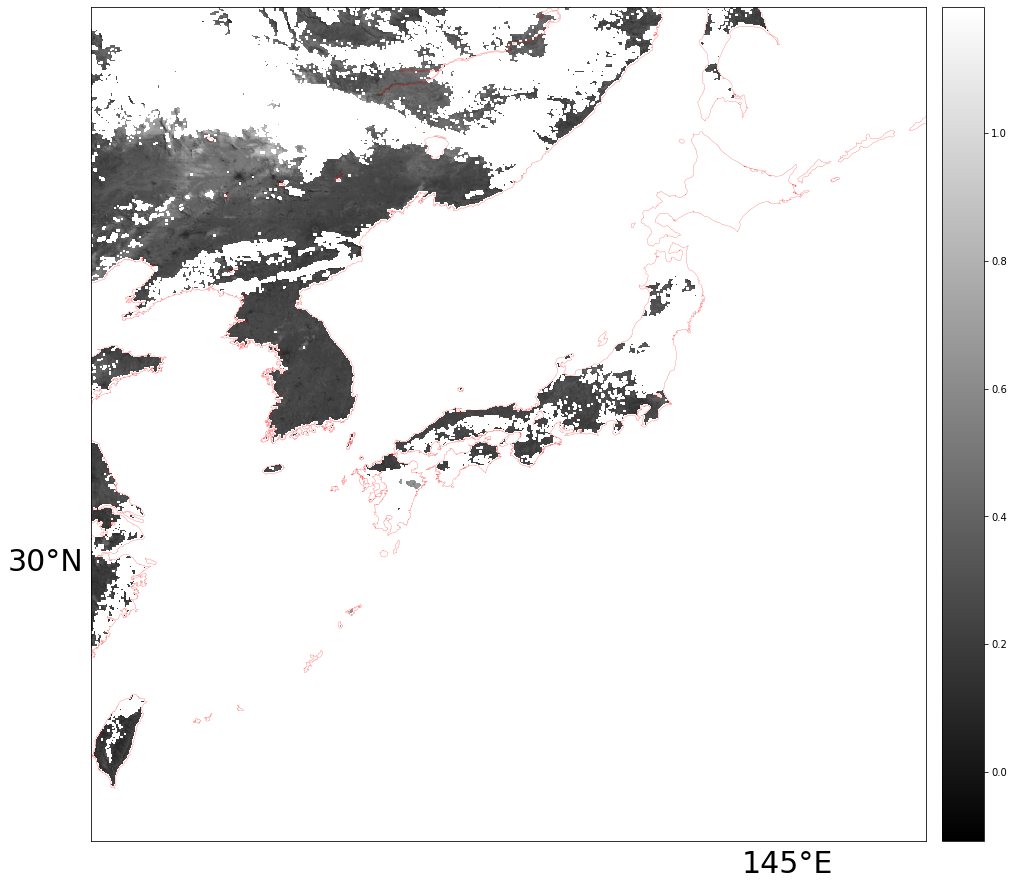

In [72]:
fig = plt.figure(figsize=(16,16))
m = Basemap(projection='cyl', resolution='i',
            llcrnrlat=20, urcrnrlat = 50,
            llcrnrlon=120, urcrnrlon = 150,
            lon_0=155, lat_0=0)  

m.drawcoastlines(linewidth=0.2,color='r')
m.drawparallels(np.arange(-60, 61, 30), labels=[1,0,0,0], fontsize=30,linewidth=0)
m.drawmeridians(np.arange(85, 206, 30), labels=[0,0,0,1], fontsize=30,linewidth=0)

m.imshow(sr,origin='upper',cmap = 'gray')
cb = m.colorbar()
# cb.set_ticks(np.linspace(0.5,15.5,17))
# cb.set_ticklabels(labels,size=20)
# plt.title('MODIS Land cover \n MCD12Q1',fontsize='30',y=1.01)
plt.show()

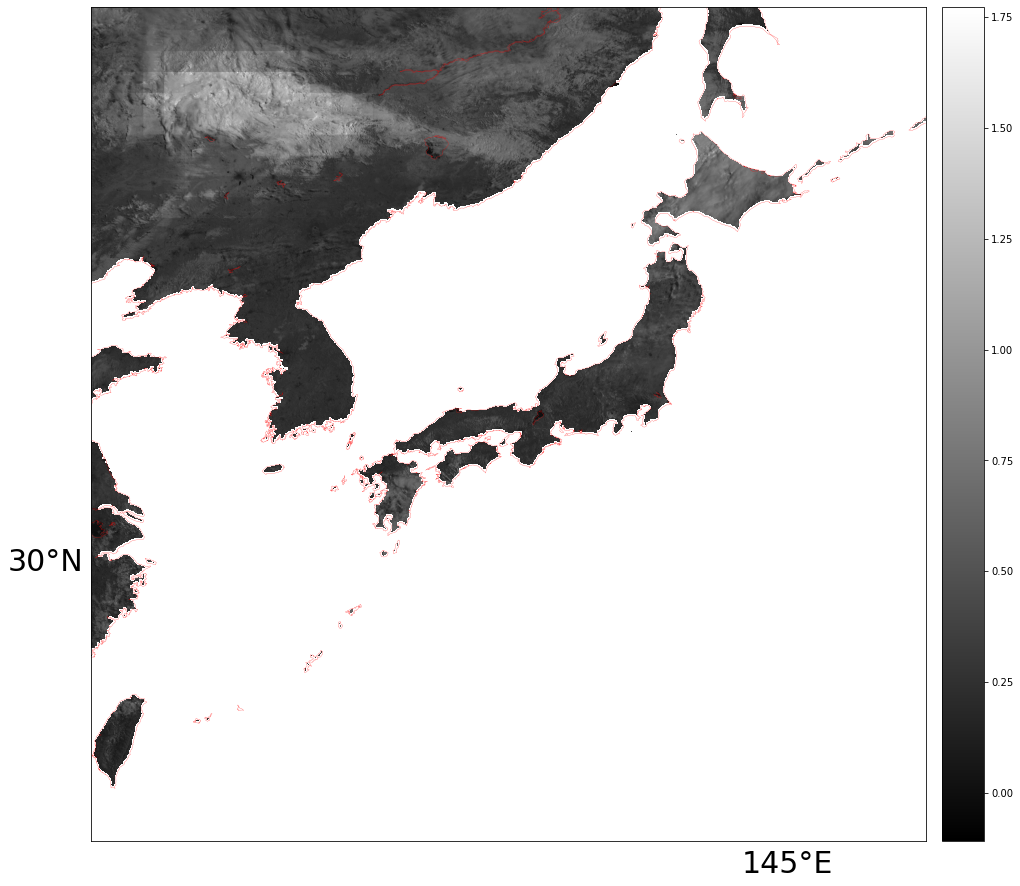

In [45]:
fig = plt.figure(figsize=(16,16))
m = Basemap(projection='cyl', resolution='i',
            llcrnrlat=20, urcrnrlat = 50,
            llcrnrlon=120, urcrnrlon = 150,
            lon_0=155, lat_0=0)  

m.drawcoastlines(linewidth=0.2,color='r')
m.drawparallels(np.arange(-60, 61, 30), labels=[1,0,0,0], fontsize=30,linewidth=0)
m.drawmeridians(np.arange(85, 206, 30), labels=[0,0,0,1], fontsize=30,linewidth=0)

m.imshow(SR,origin='upper',cmap = 'gray',interpolation = None)
cb = m.colorbar()
# cb.set_ticks(np.linspace(0.5,15.5,17))
# cb.set_ticklabels(labels,size=20)
# plt.title('MODIS Land cover \n MCD12Q1',fontsize='30',y=1.01)
plt.show()

# Fitting Least squares / Multiple linear regression

In [ ]:
np.array(Ref)[:,0].reshape(-1,1).shape

In [219]:

# Ref = Ref.reshape(36, 2300705)
def fitting(i):
    
    # k = np.hstack((np.array(kvol)[:,i].reshape(-1,1),np.array(kgeo)[:,i].reshape(-1,1)))
    # r = np.array(Ref)[:,i].reshape(-1,1)
    # linreg = LinearRegression()
    # model=linreg.fit(k, r)
    # fi = linreg.intercept_[0]
    # fv, fg = linreg.coef_[0]
    # return fi,fv,fg
    
    
    #cloud mask ref>0.3
    r = np.array(Ref)[:,i].reshape(-1,1)
    cm = np.where(r>0.2,False,True)
    r = r[cm].reshape(-1,1)
    k = np.hstack((np.array(kvol)[:,i].reshape(-1,1)[cm].reshape(-1,1),np.array(kgeo)[:,i].reshape(-1,1)[cm].reshape(-1,1)))
    if r.size > 0:
        linreg = LinearRegression()
        model=linreg.fit(k, r)
        fi = linreg.intercept_[0]
        fv, fg = linreg.coef_[0]
        return fi,fv,fg
    else:
        return np.nan,np.nan,np.nan

In [220]:
result = Parallel(n_jobs=40)(delayed(fitting)(i) for i in range(500,510))

In [7]:
# Multiple linear regression
from sklearn.linear_model import LinearRegression
cm = np.where(r>0.3,False,True)
# k = np.hstack((np.array(kvol).reshape(-1,1),np.array(kgeo).reshape(-1,1)))
# Ref = np.array(Ref).reshape(-1,1)
linreg = LinearRegression()
model=linreg.fit(k, Ref)
fiso = linreg.intercept_[0]
fvol, fgeo = linreg.coef_[0]
print(fiso,fvol, fgeo)

-0.17920113033038132 -1.353066338625989 -1.3619598292960196


# Fitting Result

In [221]:
fiso = np.array(result)[:,0]
fvol = np.array(result)[:,1]
fgeo = np.array(result)[:,2]

In [205]:
fvol

array([-0.42046489, -0.32247258, -0.61038935, -0.43806606, -0.60937359,
       -0.46115994, -0.44941915, -0.47805649, -0.3437671 , -0.53702741])

In [215]:
# i = (0:1000)
X = np.array(Ref)[:,500]

X = np.where(X>0.15,np.nan,X)

Y = fiso[0] + np.array(kvol)[:,500]*fvol[0] + np.array(kgeo)[:,500]*fgeo[0]

(0.0, 1.0)

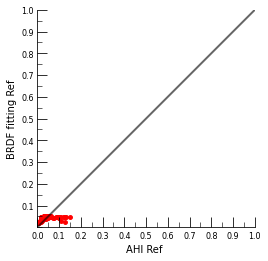

In [282]:

axis_min = 0
axis_max = 1

fig = plt.figure(figsize=(4,4))
ax1 = fig.add_subplot(111,aspect='equal')

x = np.arange(axis_min,axis_max+1)
y = 1 * x

# xx = np.arange(axis_min,axis_max+0.1,0.05) 
# yy = k * xx + b

# Calculate the point density
# xy = np.vstack([X,Y])
# z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
# idx = z.argsort()
# X, Y, z = X[idx], Y[idx], z[idx]

ax1.minorticks_on()
# x_major_locator = plt.MultipleLocator(5)
x_minor_locator = plt.MultipleLocator(0.05)
ax1.xaxis.set_minor_locator(x_minor_locator)
# ax.xaxis.set_major_locator(x_major_locator)
ax1.yaxis.set_minor_locator(x_minor_locator)
# ax.yaxis.set_major_locator(x_major_locator)

ax1.tick_params(axis="y",which='minor',length=5,direction='in',labelsize=8)
ax1.tick_params(axis="y",which='major',length=10,direction='in',labelsize=8)

ax1.tick_params(axis="x",which='minor',length=5,direction='in',labelsize=8)
ax1.tick_params(axis="x",which='major',length=10,direction='in',labelsize=8)


ax1.spines['right'].set_color('none')
ax1.spines['top'].set_color('none')


im = ax1.scatter(X,Y,marker='o', c='r',s=15)

ax1.set_xticks(np.arange(axis_min,axis_max+0.1,0.1))
ax1.set_yticks(np.arange(axis_min+0.1,axis_max+0.1,0.1))

ax1.set_xlabel("AHI Ref ",fontsize=10)
ax1.set_ylabel("BRDF fitting Ref",fontsize=10)


ax1.plot(x,y,color='k',linewidth=2,linestyle='-',alpha=0.6)
# ax1.plot(xx,yy,color='r',linewidth=2,linestyle='-') 


text_x = axis_min + (axis_max - axis_min) * 0.07
text_y = axis_max - (axis_max - axis_min) * 0.22

# ax1.text(text_x,text_y,s = 'Land Cover : {}\nN = {}\nRMSE = {}\ny = {} + {}x'.format(LC,N,rmse,b,k),fontsize=8)

# cax = add_right_cax(ax1, pad=0.06, width=0.03)
# cb = fig.colorbar(im,cax=cax)
# cb.ax.set_xlabel('Count',rotation=360)
ax1.set_xlim(axis_min,axis_max)
ax1.set_ylim(axis_min,axis_max)

In [273]:
D = np.zeros((6,37))
for i in range(1,7):
    if i == 1:
        a = Y[0:35]
        a = np.insert(a,16,np.nan)
        a = np.insert(a,36,np.nan)
        print(a.shape)
        D[i-1] = a
    else:
        a = Y[35+36*(i-2):35+36*(i-2)+36]
        a = np.insert(a,16,np.nan)
        print(a.shape)
        D[i-1] = a

(37,)
(37,)
(37,)
(37,)
(37,)
(37,)


In [279]:
np.nanmax(D,axis=0)

<ipython-input-279-304932008d5d>:1: RuntimeWarning: All-NaN slice encountered
  np.nanmax(D,axis=0)


array([0.04566489, 0.02500171, 0.02709727, 0.02909809, 0.03097568,
       0.03276393, 0.03443746, 0.03602541, 0.03752169, 0.0389218 ,
       0.04023771, 0.04148213, 0.042635  , 0.04370864, 0.04467686,
       0.04559061,        nan, 0.04717655, 0.04784564, 0.048447  ,
       0.04897502, 0.04941217, 0.04977171, 0.05005442, 0.05025875,
       0.05037846, 0.05041078, 0.05036591, 0.05022658, 0.0500428 ,
       0.04981976, 0.04951084, 0.04908967, 0.04857209, 0.04796807,
       0.04724924, 0.04643356])

<ipython-input-281-b8932e9a8ed2>:16: RuntimeWarning: All-NaN slice encountered
  ax1.plot(np.arange(0,37,1),np.nanmax(D,axis=0),color = 'tan',marker="o",markersize=1,linewidth=1,label='BRDF')


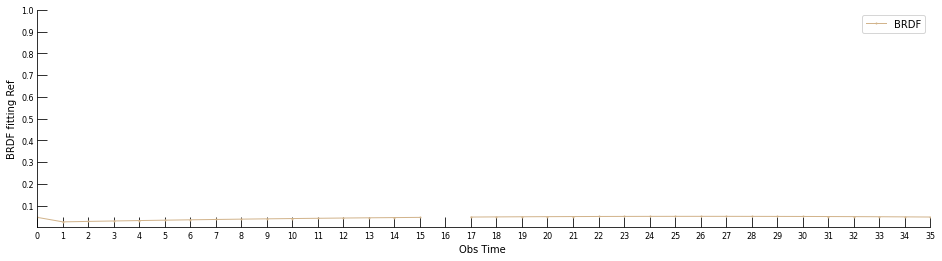

In [281]:
axis_min = 0
axis_max = 1

fig = plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(111)


ax1.tick_params(axis="y",which='major',length=10,direction='in',labelsize=8)
ax1.tick_params(axis="x",which='major',length=10,direction='in',labelsize=8)


ax1.spines['right'].set_color('none')
ax1.spines['top'].set_color('none')

# ax1.plot(label,X,color = 'k',marker="o",markersize=1,linewidth=1,label='Ref')
ax1.plot(np.arange(0,37,1),np.nanmax(D,axis=0),color = 'tan',marker="o",markersize=1,linewidth=1,label='BRDF')


ax1.set_xticks(np.linspace(0,35,36))
ax1.set_yticks(np.arange(axis_min+0.1,1.1,0.1))

ax1.set_xlabel("Obs Time ",fontsize=10)
ax1.set_ylabel("BRDF fitting Ref",fontsize=10)



text_x = axis_min + (axis_max - axis_min) * 0.07
text_y = axis_max - (axis_max - axis_min) * 0.22

ax1.set_xlim(axis_min,35)
ax1.set_ylim(axis_min,axis_max)
plt.legend()

(0.0, 1.0)

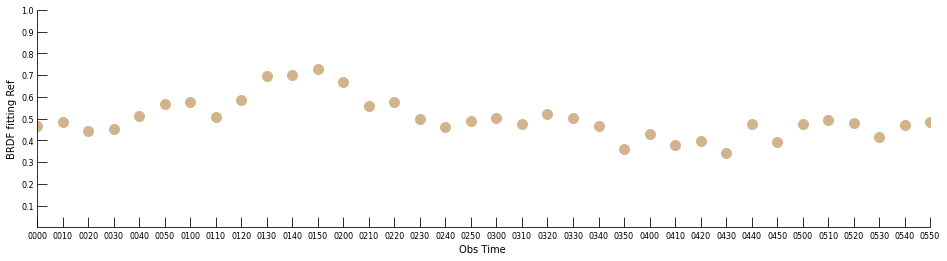

In [299]:

axis_min = 0
axis_max = 1

fig = plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(111)

# x = np.arange(axis_min,11)
# y = 1 * x

# xx = np.arange(axis_min,axis_max+0.1,0.05) 
# yy = k * xx + b

# Calculate the point density
# xy = np.vstack([X,Y])
# z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
# idx = z.argsort()
# X, Y, z = X[idx], Y[idx], z[idx]



ax1.tick_params(axis="y",which='major',length=10,direction='in',labelsize=8)
ax1.tick_params(axis="x",which='major',length=10,direction='in',labelsize=8)


ax1.spines['right'].set_color('none')
ax1.spines['top'].set_color('none')

ax1.plot(label,X,color = 'tan',marker="o",markersize=10,linewidth=0)

ax1.set_xticks(np.linspace(0,35,36))
ax1.set_yticks(np.arange(axis_min+0.1,1.1,0.1))

ax1.set_xlabel("Obs Time ",fontsize=10)
ax1.set_ylabel("BRDF fitting Ref",fontsize=10)



text_x = axis_min + (axis_max - axis_min) * 0.07
text_y = axis_max - (axis_max - axis_min) * 0.22

ax1.set_xlim(axis_min,35)
ax1.set_ylim(axis_min,axis_max)

# Reshape to 2d-array

In [ ]:
Water_idx = get_water_idx()

In [186]:
Result = np.full((3000*3000),np.nan)
Result[Water_idx] = kvol[0]
Result = Result.reshape(3000,3000)

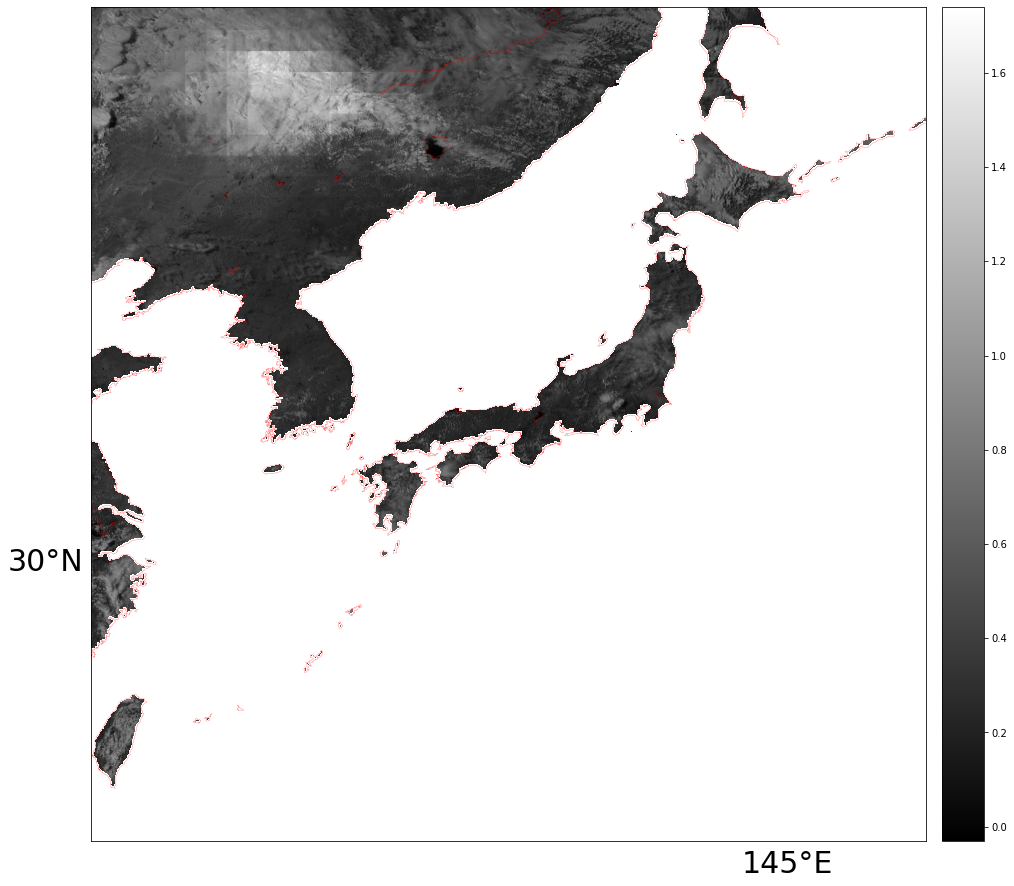

In [213]:
fig = plt.figure(figsize=(16,16))
m = Basemap(projection='cyl', resolution='i',
            llcrnrlat=20, urcrnrlat = 50,
            llcrnrlon=120, urcrnrlon = 150,
            lon_0=155, lat_0=0)  

m.drawcoastlines(linewidth=0.2,color='r')
m.drawparallels(np.arange(-60, 61, 30), labels=[1,0,0,0], fontsize=30,linewidth=0)
m.drawmeridians(np.arange(85, 206, 30), labels=[0,0,0,1], fontsize=30,linewidth=0)

m.imshow(SR,origin='upper',cmap = 'gray',interpolation = None)
cb = m.colorbar()
# cb.set_ticks(np.linspace(0.5,15.5,17))
# cb.set_ticklabels(labels,size=20)
# plt.title('MODIS Land cover \n MCD12Q1',fontsize='30',y=1.01)
plt.show()

In [229]:
date_start = '2018-07-21 00:00'
date_end = '2018-07-21 06:00'
date_t = dt.timedelta(minutes=10)
# date_t = dt.timedelta(minutes=30)
date_s = dt.datetime.strptime(date_start, "%Y-%m-%d %H:%M")
date_e = dt.datetime.strptime(date_end, "%Y-%m-%d %H:%M")
date_time_now = date_s
label = []
while date_time_now <= date_e:
    # print(date_time_now)
    start_time = T.time()
    YYYY,MM,DD,HH,MIN,date= Time_split(date_time_now)
    label.append(HH+MIN)
    date_time_now = date_time_now + date_t